<a href="https://colab.research.google.com/github/tronglinux123/AI-Project/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.cloud import bigquery
from google.colab import auth, drive
import os
# Mount to Google Drive if data on Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/doan_demo')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/doan_demo'

In [ ]:
from typing import Callable
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import warnings
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import gc
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv('x_ray_and_features_data.csv')

diseases = ['pneumonia', 'tuberculosis', 'bronchitis', 'arthritis', 'fracture', 'lung_cancer', 'scoliosis', 'lung_infection']
mimic_feats = ['diabete', 'age', 'hiv', 'oxygen', 'heart_rate', 'temperature', 'hemoglobin', 'rbc', 'wbc', 'smoke', 'cough']
img_feats = [str(x) for x in range(18)]


In [ ]:
# Count the number of patients
dc = df[diseases].apply(pd.Series.value_counts)
dc



,pneumonia,tuberculosis,bronchitis,arthritis,fracture,lung_cancer,scoliosis,lung_infection
0,21103,28312,27598,27892,27005,21296,28933,28131
1,7980,771,1485,1191,2078,7787,150,952


In [ ]:
percent = dc.div(dc.sum(axis=0), axis=1) * 100
percent_disease = percent.loc[1]

percent_disease

,1
pneumonia,27.438710
tuberculosis,2.651033
bronchitis,5.106076
arthritis,4.095176
fracture,7.145068
lung_cancer,26.775092
scoliosis,0.515765
lung_infection,3.273390


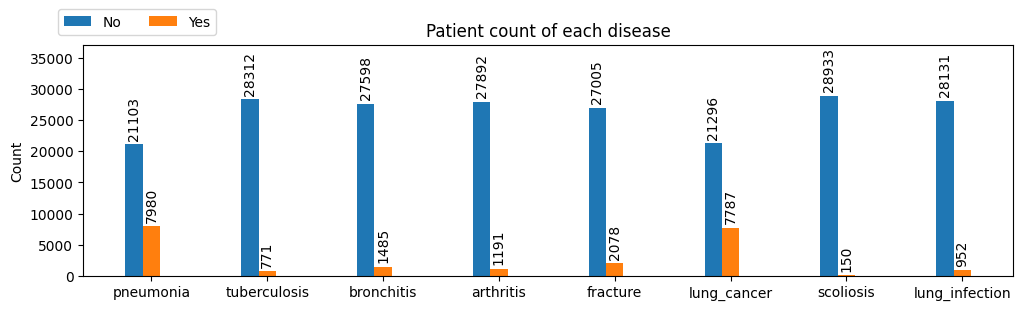

In [ ]:
# Plot out the count to see the ratio
_,ax = plt.subplots(figsize=(12,3))
w = 0.15
x = np.arange(len(diseases))
for j,v in enumerate([0,1]):
  offset = w*j
  rects = ax.bar(x+offset, dc.iloc[v], w, label='Yes' if v else 'No')
  ax.bar_label(rects, padding=3, fmt='%.f', rotation=90)
ax.set_xticks(x + w, diseases)
ax.legend(loc='right', ncols=2, bbox_to_anchor=(0.15,1.1))
ax.set_ylabel('Count')
ax.set_ylim(0,37000)
ax.set_title('Patient count of each disease')
plt.show()

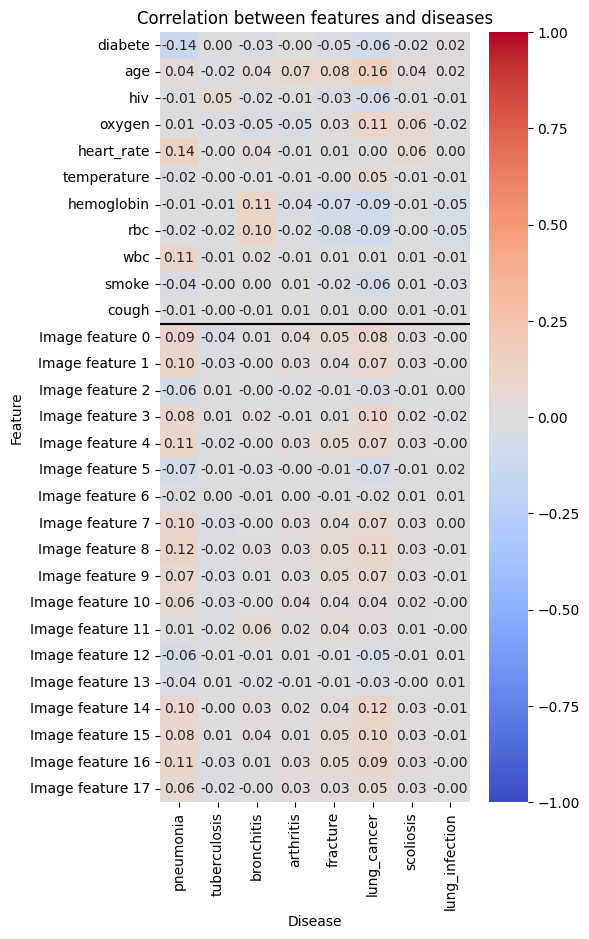

In [ ]:
# Correlation plotting

# Function for formatting label name for better explanation
mdl_fmt = lambda s: f'Image feature {s}' if len(s)<3 else s

# Get the correlation
co = df[mimic_feats+img_feats+diseases].corr()

# Plotting
_,ax = plt.subplots(figsize=(5,10))
sns.heatmap(co.loc[mimic_feats+img_feats,diseases], cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", ax=ax)
ax.set_title('Correlation between features and diseases')
ax.set_xlabel('Disease')
ax.set_ylabel('Feature')
ax.set_yticklabels([mdl_fmt(item.get_text()) for item in ax.get_yticklabels()])
# Draw line to separate the categories
ax.hlines([11], *ax.get_xlim(), colors='black')

plt.show()

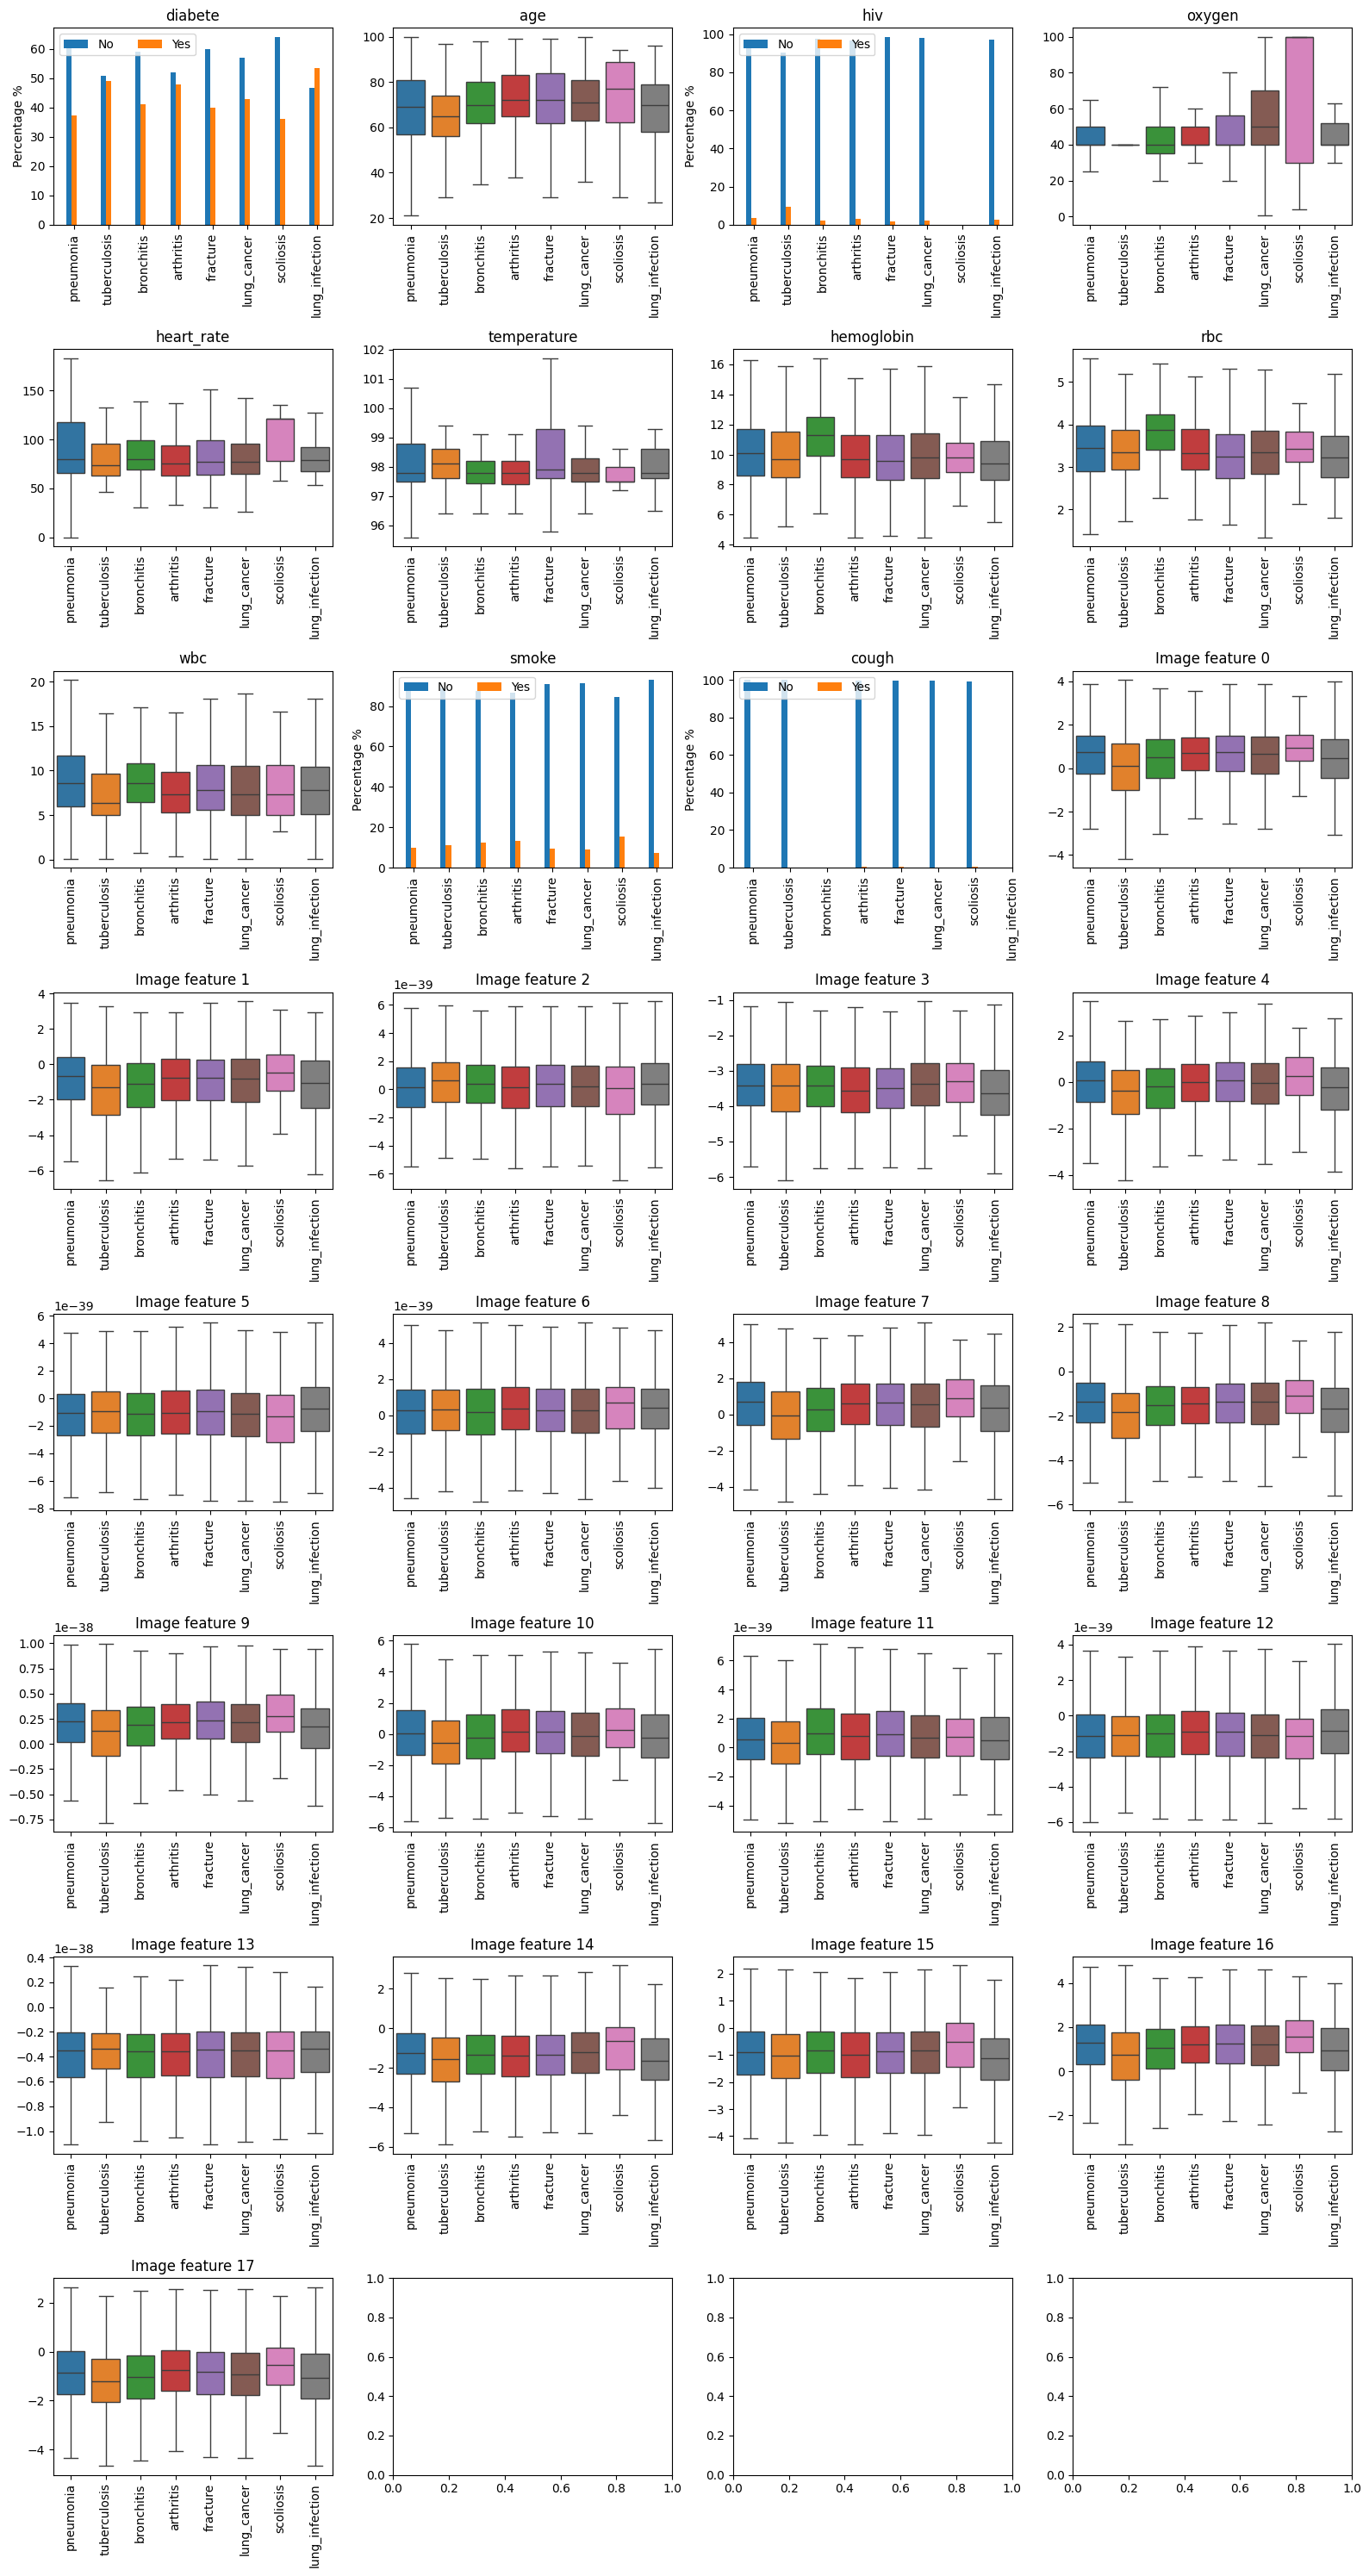

In [ ]:
n = len(mimic_feats+img_feats)
c = 4     # Number of plots per row
w = 0.15  # Width of bars
# Plot out with c plots per row
fig, ax = plt.subplots(n//c + (n%c > 0), c, figsize=(16, 30))

# Plot for each feature
for i,f in enumerate(mimic_feats+img_feats):
  new_df = pd.DataFrame({d:df.apply(lambda x: x[f] if x[d]==1 else np.nan, axis=1) for d in diseases})
  # If binary features, bar plot
  if len(df[f].unique()) == 2:
    cdf = new_df.apply(pd.value_counts).apply(lambda x: x/sum(x)*100, axis=0)
    x=np.arange(len(diseases))
    for j,v in enumerate([0,1]):
      offset = w*j
      rects = ax[i//c, i%c].bar(x+offset, cdf.iloc[v], w, label='Yes' if v else 'No')
      #plt.bar_label(rects, padding=3, fmt='%.f')
    ax[i//c, i%c].set_xticks(x + w, diseases)
    ax[i//c, i%c].legend(loc='upper left', ncols=2)
    ax[i//c, i%c].set_ylabel('Percentage %')
  # Otherwise, box plot the majority of data, no outliers
  else:
    sns.boxplot(new_df, ax=ax[i//c, i%c], showfliers=False)
  ax[i//c, i%c].set_title(mdl_fmt(f))
  ax[i//c, i%c].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()